In [48]:
# !pip install tensorflow
# !pip install imbalanced-learn

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [51]:
df_train_original = pd.read_csv('outputs/preprocessed_data/df_train.csv')
df_test_original = pd.read_csv('outputs/preprocessed_data/df_test.csv')

In [71]:
df_train_original.columns

Index(['AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE',
       'DAYS_REGISTRATION', 'AMT_CREDIT', 'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL',
       'DAYS_ID_PUBLISH', 'SK_ID_CURR', 'TARGET'],
      dtype='object')

### Perform a preprocessing step on the train data

In [52]:
# Drop columns with all NaN values
df_train_original = df_train_original.dropna(axis=1, how='all')

# Drop columns with more than 95% NaN values
threshold = len(df_train_original) * 0.95
df_train_original = df_train_original.dropna(axis=1, thresh=threshold)

# Drop NaN values
df_train_original = df_train_original.dropna()

# One-hot encode categorical variables
df_train_original = pd.get_dummies(df_train_original)

### Perform a preprocessing step on the test data

In [53]:
# Drop columns with all NaN values
df_test_original = df_test_original.dropna(axis=1, how='all')

# Drop columns with more than 95% NaN values
threshold = len(df_test_original) * 0.95
df_test_original = df_test_original.dropna(axis=1, thresh=threshold)

# Drop NaN values
df_test_original = df_test_original.dropna()

# One-hot encode categorical variables
df_test_original = pd.get_dummies(df_test_original)

### Remove columns from `df_train_original` that do not exist in `df_test_original`

In [54]:
intersection = list(set(df_train_original.columns) &
                  set(df_test_original.columns))
intersection.append("TARGET")

df_train_original = df_train_original[intersection]

In [55]:
# Separate features and target variable from df_train
X = df_train_original
y = df_train_original['TARGET']

In [56]:
# Define the SMOTE sampler
smote = SMOTE(sampling_strategy=0.5, k_neighbors=10,
              random_state=42, n_jobs=-1)

# Display the number of samples before SMOTE
print("Number of samples before SMOTE:")
print("X_train_scaled:", X.shape[0])
print("y_train:", y.shape[0])

# Apply SMOTE
X_train_balanced, y_train_balanced = smote.fit_resample(X, y)

# Display the number of samples after SMOTE
print("\nNumber of samples after SMOTE:")
print("X_train_balanced:", X_train_balanced.shape[0])
print("y_train_balanced:", y_train_balanced.shape[0])

Number of samples before SMOTE:
X_train_scaled: 304531
y_train: 304531


c:\Work\Home Credit Default Risk\.venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(



Number of samples after SMOTE:
X_train_balanced: 419796
y_train_balanced: 419796


In [57]:
X_train_balanced = X_train_balanced.drop(columns=['TARGET', 'SK_ID_CURR'])

In [58]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data
X_val_scaled = scaler.transform(X_val)

# Ensure df_test has the same columns as X_train
df_test_aligned = df_test_original[X_train.columns]

# Transform the test data
X_test_scaled = scaler.transform(df_test_aligned)

In [59]:
model = Sequential()
model.add(Dense(1024, input_dim=X_train_balanced.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Work\Home Credit Default Risk\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [60]:
# Compile the model with class weights
# class_weights = {0: 1., 1: 10.}  # Adjust the weights as needed


# Compile the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping

early_stopping = EarlyStopping(
monitor='val_loss', patience=5, restore_best_weights=True)

In [61]:
history = model.fit(X_train_scaled, y_train, validation_data=(
    X_val_scaled, y_val), epochs=30, batch_size=256, callbacks=[early_stopping])

Epoch 1/30
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 52s 34ms/step - accuracy: 0.6572 - loss: 0.6295 - val_accuracy: 0.7371 - val_loss: 0.5323
Epoch 2/30
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - accuracy: 0.7457 - loss: 0.5388 - val_accuracy: 0.7727 - val_loss: 0.4934
Epoch 3/30
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 63s 48ms/step - accuracy: 0.7585 - loss: 0.5153 - val_accuracy: 0.7754 - val_loss: 0.4847
Epoch 4/30
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 83s 49ms/step - accuracy: 0.7669 - loss: 0.4992 - val_accuracy: 0.7889 - val_loss: 0.4697
Epoch 5/30
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 77s 44ms/step - accuracy: 0.7733 - loss: 0.4890 - val_accuracy: 0.7919 - val_loss: 0.4585
Epoch 6/30
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 86s 47ms/step - accuracy: 0.7789 - loss: 0.4815 - val_accuracy: 0.7877 - val_loss: 0.4634
Epoch 7/30
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 54s 41ms/step - accuracy: 0.7840 - loss: 0.4740 - val_accuracy: 0.7960 - val_loss: 0.4518
Epoch 8/30
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 78s 38ms/step - accuracy: 0.7864 -

In [66]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val)
print(f'Validation Accuracy: {val_accuracy}')


2624/2624 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8096 - loss: 0.4364
Validation Accuracy: 0.80768221616745


In [67]:
# Predict on the validation set
y_val_pred = model.predict(X_val_scaled).round().astype(int)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)

# Calculate the ROC AUC score
roc_score = roc_auc_score(y_val, y_val_pred)

# Display the ROC AUC score
print("ROC AUC Score:", roc_score)

2624/2624 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
ROC AUC Score: 0.7514120466005771


In [68]:
# Print classification report
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86     55916
           1       0.79      0.58      0.67     28044

    accuracy                           0.81     83960
   macro avg       0.80      0.75      0.77     83960
weighted avg       0.81      0.81      0.80     83960



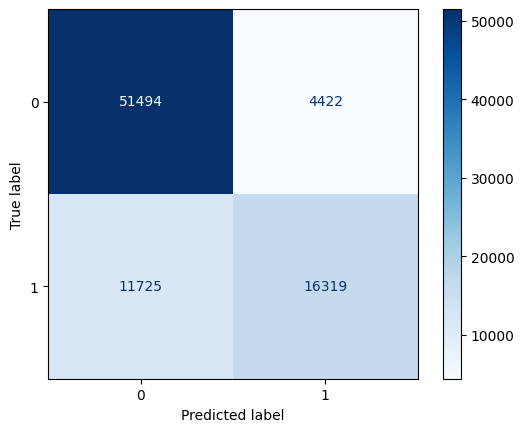

In [69]:
# Create the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [15]:
# Predict on the test set
df_test_original['TARGET'] = model.predict(X_test_scaled).round().astype(int)

# Export the predictions to a CSV file
df_test_original.to_csv('df_test_original_predictions_deep_learning.csv', index=False)

1493/1493 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
